In [ ]:
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
import keras
import re
import os
from keras.models import load_model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Bidirectional,Masking,SpatialDropout1D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

In [5]:
import pandas as pd

In [ ]:
file_path = 'test_data.txt'

with open(file_path, 'r') as files:
    content = files.read()

lines = content.strip().split('\n')

titles = []
genres = []
descriptions = []

for line in lines:
    parts = line.split(' ::: ')
    if len(parts) == 4:
        movie_id, title,genre, description = parts
        titles.append(title.strip())
        genres.append(genre.strip())
        descriptions.append(description.strip())

df = pd.DataFrame({
    'title': titles,
    'genre': genres,
    'description': descriptions
})

print(df)

In [6]:
train_data = pd.read_csv("train_data.txt", delimiter=':::', header=None, engine='python')
test_data = pd.read_csv("test_data.txt", delimiter=':::', header=None, engine='python')
test_data_solution = pd.read_csv("test_data_solution.txt", delimiter=':::', header=None, engine='python')

In [7]:
print("shape",train_data.shape)

shape (54214, 4)


In [8]:
train_data.head()

,0,1,2,3
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [10]:
print("shape",test_data_solution.shape)

shape (54200, 4)


In [11]:
test_data_solution.head()

,0,1,2,3
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


In [12]:
df = pd.concat([train_data, test_data_solution])

In [13]:
df.columns = ["id", "Title", "Genre", "Description"]

In [14]:
print(df.head())

   id                               Title       Genre  \
0   1       Oscar et la dame rose (2009)       drama    
1   2                       Cupid (1997)    thriller    
2   3   Young, Wild and Wonderful (1980)       adult    
3   4              The Secret Sin (1915)       drama    
4   5             The Unrecovered (2007)       drama    

                                         Description  
0   Listening in to a conversation between his do...  
1   A brother and sister with a past incestuous r...  
2   As the bus empties the students for their fie...  
3   To help their unemployed father make ends mee...  
4   The film's title refers not only to the un-re...  


In [15]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
id             0
Title          0
Genre          0
Description    0
dtype: int64


In [16]:
import string

df['Description'] = df['Description'].str.lower()

# Removing punctuation
df['Description'] = df['Description'].apply(lambda x: ''.join([c for c in x if c not in string.punctuation]))

# Tokenization (split text into words)
df['Description'] = df['Description'].apply(lambda x: x.split())

In [18]:
df = pd.get_dummies(df, columns=['Genre'])

In [19]:
#training
from sklearn.model_selection import train_test_split

X = df['Description']
y = df.drop(['id', 'Title', 'Description'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df.head()

,id,Title,Description,Genre_ action,Genre_ adult,Genre_ adventure,Genre_ animation,Genre_ biography,Genre_ comedy,Genre_ crime,...,Genre_ news,Genre_ reality-tv,Genre_ romance,Genre_ sci-fi,Genre_ short,Genre_ sport,Genre_ talk-show,Genre_ thriller,Genre_ war,Genre_ western
0,1,Oscar et la dame rose (2009),"[listening, in, to, a, conversation, between, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Cupid (1997),"[a, brother, and, sister, with, a, past, inces...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,"Young, Wild and Wonderful (1980)","[as, the, bus, empties, the, students, for, th...",0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,The Secret Sin (1915),"[to, help, their, unemployed, father, make, en...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,The Unrecovered (2007),"[the, films, title, refers, not, only, to, the...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


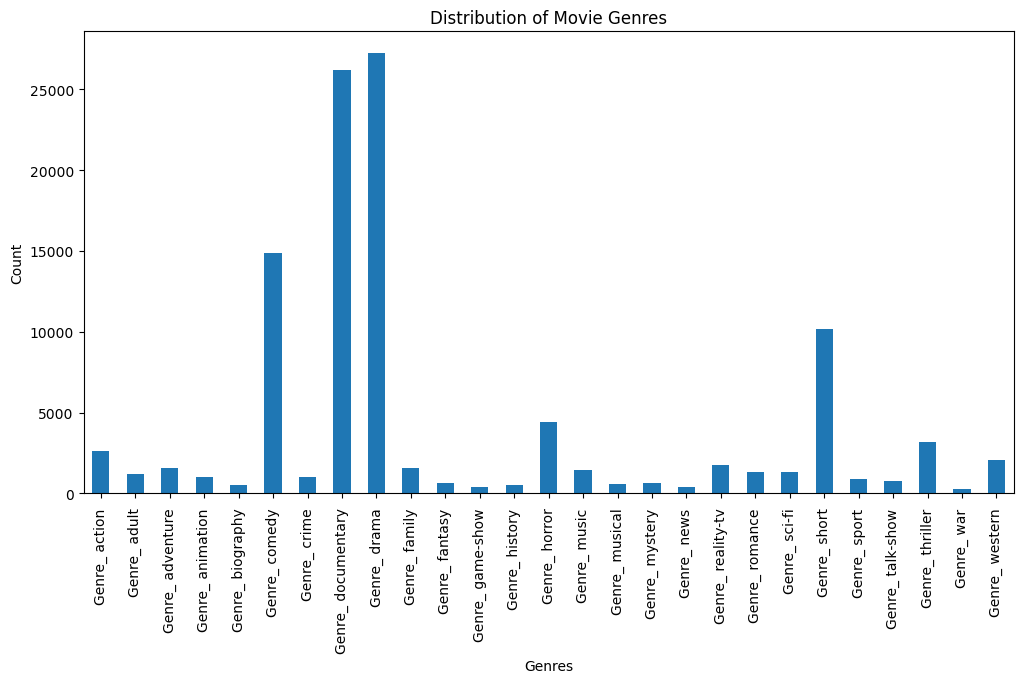

In [20]:
import matplotlib.pyplot as plt

# Extracting genre columns for analysis
genre_columns = df.columns[3:]  # Selecting columns related to movie genres

# Calculating genre counts for visualization
genre_counts = df[genre_columns].sum()

# Creating a bar chart to visualize the distribution of movie genres
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Distribution of Movie Genres')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()